##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# ガウス過程による潜在変数モデル

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/probability/examples/Gaussian_Process_Latent_Variable_Model"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Gaussian_Process_Latent_Variable_Model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Gaussian_Process_Latent_Variable_Model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/probability/examples/Gaussian_Process_Latent_Variable_Model.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

潜在変数モデルは、高次元データの隠れた構造を捉えようとします。例には主成分分析（PCA）と因子分析が含まれます。ガウス過程は、局所的な相関構造と不確実性を柔軟に捉えることができる「ノンパラメトリック」モデルです。ガウス過程による潜在変数モデル（[Lawrence, 2004](https://papers.nips.cc/paper/2540-gaussian-process-latent-variable-models-for-visualisation-of-high-dimensional-data.pdf)）には、これらの概念が組み合わされています。

## 背景: ガウス過程

ガウス過程は、有限サブセットの周辺分布が多変量正規分布である、確率変数の集合体です。詳細については、回帰における GP を説明した「[TensorFlow Probability におけるガウス過程回帰](https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Regression_In_TFP.ipynb)」をご覧ください。

GP が構成する集合体の各確率変数にラベルを付けるために、*インデックスセット*と言われるものを使用します。有限インデックスセットの場合は、多変量正規分布が得られます。ただし GP は、*無限*の集合体を考慮したときに興味深くなります。*$D$ 次元空間のすべてのポイント*に対する確率変数がある $\mathbb{R}^D$ のようなインデックスセットの場合、GP はランダム*関数*に対する分布として考えられます。このような GP から 1 つをドローできたとした場合、それは $\mathbb{R}^D$ の各ポイントに（同時に正規に分布された）値を代入します。この Colab では、$\mathbb{R}^D$ の GP に焦点を当てます。

正規分布は、その一次および二次統計によって完全に判定されます。実際、正規分布を定義する方法の 1 つとして、高次キュムラントがすべてゼロであるものとすることができます。これは GP にも当てはまることで、平均値と共分散<sup></sup>** を記述することで、GP を完全に指定します。有限次元の多変量正規分布を思い出せば、平均値はベクトルであり、共分散は正方形の対称正定値行列です。無限次元の GP では、これらの構造は、インデックスセットの各ポイントで定義される平均関数* $m : \mathbb{R}^D \to \mathbb{R}$ と共分散「*カーネル*」関数 $k : \mathbb{R}^D \times \mathbb{R}^D \to \mathbb{R}$ に一般化されます。カーネル関数は[正定値](https://en.wikipedia.org/wiki/Positive-definite_function)であり、基本的に有限の点のセットに制限されて、正定値行列を生成することを意味します。

ほとんどの GP の構造は、共分散カーネル関数から派生するもので、この関数はサンプリングされた関数の値が近隣の（またはそれほど近隣でない）ポイントでどれくらい異なるかを表します。共分散関数では、それぞれに異なる程度の滑らかさを促進しますが、一般的に使用されるカーネル関数の 1 つは「指数二次」（別名: ガウス、二乗指数、または動径基底関数）$k(x, x') = \sigma^2 e^{(x - x^2) / \lambda^2}$ です。その他の例は、David Duvenaud の[カーネルクックブックのページ](https://www.cs.toronto.edu/~duvenaud/cookbook/)と正規のテキストである「[機械学習のガウス過程](http://www.gaussianprocess.org/gpml/)」で説明されています。

<sub>* 無限インデックスセットでは、整合性条件も必要です。GP の定義は有限周辺分布でなされているため、これらの周辺分布が、周辺分布が取得された次元に関係なく、整合していることが必要です。これは、確率的過程の理論におけるある程度高度な内容であるため、このチュートリアルでは説明していません。最終的にうまく行くことは十分に言えます！</sub>

## GP を適用する: 回帰と潜在変数モデル

GP を使用する 1 つの方法として、回帰が挙げられます。入力 ${x_i}*{i=1}^N$（インデックスセットの要素）と観測値 ${y_i}*{i=1}^N$ の形式の一連の観測データが与えられた場合、これらを使用して、新しいポイントセット ${x_j^*}_{j=1}^M$ で事後予測分布を形成できます。分布はすべてガウスであるため、これは簡単な線形代数に要約されます（ただし、必要な計算では、データポイントの数にランタイム *cubeic* があり、データポイントの数に 2 次の空間が必要です。これは GP の使用における主要な制限要因であり、現在の多くの研究は、正確な事後推論の計算上実行可能な代替案に焦点を合わせています。GP 回帰の詳細な説明については、[TFP における GP 回帰の Colab](https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Regression_In_TFP.ipynb) をご覧ください。

GP を使用できるもう 1 つの方法は、潜在変数モデルです。高次元の観測（画像など）の集合体がある場合、いくつかの低次元の潜在構造を仮定することができます。潜在構造を条件として、多数の出力（画像内のピクセル）は互いに独立していると仮定します。このモデルのトレーニングには次の作業が含まれます。

1. モデルパラメータを最適化する（カーネル関数パラメータや観測ノイズ分散など）
2. トレーニングの観測（画像）ごとに、インデックスセット内の対応するポイントの位置を見つける。すべての最適化は、データの対数周辺尤度を最大化することで行えます。

## インポート

In [ ]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## MNIST データを読み込む

In [ ]:
# Load the MNIST data set and isolate a subset of it.
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
N = 1000
small_x_train = x_train[:N, ...].astype(np.float64) / 256.
small_y_train = y_train[:N]

11501568/11490434 [==============================] - 0s 0us/step


## トレーニング可能な変数を準備する

3 つのモデルパラメータと潜在入力を同時にトレーニングします。

In [ ]:
# Create some trainable model parameters. We will constrain them to be strictly
# positive when constructing the kernel and the GP.
unconstrained_amplitude = tf.Variable(np.float64(1.), name='amplitude')
unconstrained_length_scale = tf.Variable(np.float64(1.), name='length_scale')
unconstrained_observation_noise = tf.Variable(np.float64(1.), name='observation_noise')

In [ ]:
# We need to flatten the images and, somewhat unintuitively, transpose from
# shape [100, 784] to [784, 100]. This is because the 784 pixels will be
# treated as *independent* conditioned on the latent inputs, meaning we really
# have a batch of 784 GP's with 100 index_points.
observations_ = small_x_train.reshape(N, -1).transpose()

# Create a collection of N 2-dimensional index points that will represent our
# latent embeddings of the data. (Lawrence, 2004) prescribes initializing these
# with PCA, but a random initialization actually gives not-too-bad results, so
# we use this for simplicity. For a fun exercise, try doing the
# PCA-initialization yourself!
init_ = np.random.normal(size=(N, 2))
latent_index_points = tf.Variable(init_, name='latent_index_points')

## モデルとトレーニング演算子を構築する

In [ ]:
# Create our kernel and GP distribution
EPS = np.finfo(np.float64).eps

def create_kernel():
  amplitude = tf.math.softplus(EPS + unconstrained_amplitude)
  length_scale = tf.math.softplus(EPS + unconstrained_length_scale)
  kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)
  return kernel

def loss_fn():
  observation_noise_variance = tf.math.softplus(
      EPS + unconstrained_observation_noise)
  gp = tfd.GaussianProcess(
      kernel=create_kernel(),
      index_points=latent_index_points,
      observation_noise_variance=observation_noise_variance)
  log_probs = gp.log_prob(observations_, name='log_prob')
  return -tf.reduce_mean(log_probs)

trainable_variables = [unconstrained_amplitude,
                       unconstrained_length_scale,
                       unconstrained_observation_noise,
                       latent_index_points]

optimizer = tf.optimizers.Adam(learning_rate=1.0)

@tf.function(autograph=False, jit_compile=True)
def train_model():
  with tf.GradientTape() as tape:
    loss_value = loss_fn()
  grads = tape.gradient(loss_value, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss_value

## トレーニングして生成された潜在的な埋め込みをプロットする

In [ ]:
# Initialize variables and train!
num_iters = 100
log_interval = 20
lips = np.zeros((num_iters, N, 2), np.float64)
for i in range(num_iters):
  loss = train_model()
  lips[i] = latent_index_points.numpy()
  if i % log_interval == 0 or i + 1 == num_iters:
    print("Loss at step %d: %f" % (i, loss))

Loss at step 0: 1108.121688
Loss at step 20: -159.633761
Loss at step 40: -263.014394
Loss at step 60: -283.713056
Loss at step 80: -288.709413
Loss at step 99: -289.662253


## 結果をプロットする

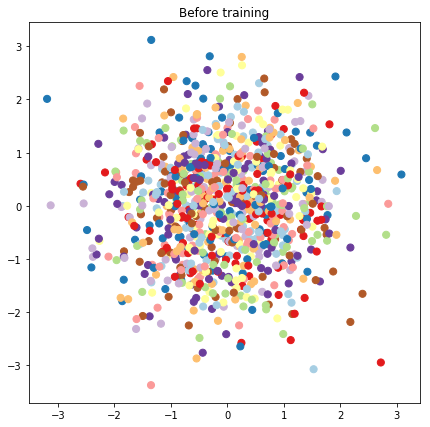

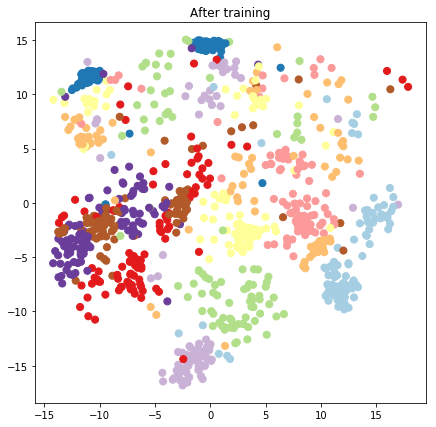

In [ ]:
# Plot the latent locations before and after training
plt.figure(figsize=(7, 7))
plt.title("Before training")
plt.grid(False)
plt.scatter(x=init_[:, 0], y=init_[:, 1],
           c=y_train[:N], cmap=plt.get_cmap('Paired'), s=50)
plt.show()

plt.figure(figsize=(7, 7))
plt.title("After training")
plt.grid(False)
plt.scatter(x=lips[-1, :, 0], y=lips[-1, :, 1],
           c=y_train[:N], cmap=plt.get_cmap('Paired'), s=50)
plt.show()

## 予測モデルとサンプリング演算子を構築する

In [ ]:
# We'll draw samples at evenly spaced points on a 10x10 grid in the latent
# input space. 
sample_grid_points = 10
grid_ = np.linspace(-4, 4, sample_grid_points).astype(np.float64)
# Create a 10x10 grid of 2-vectors, for a total shape [10, 10, 2]
grid_ = np.stack(np.meshgrid(grid_, grid_), axis=-1)

# This part's a bit subtle! What we defined above was a batch of 784 (=28x28)
# independent GP distributions over the input space. Each one corresponds to a
# single pixel of an MNIST image. Now what we'd like to do is draw 100 (=10x10)
# *independent* samples, each one separately conditioned on all the observations
# as well as the learned latent input locations above.
#
# The GP regression model below will define a batch of 784 independent
# posteriors. We'd like to get 100 independent samples each at a different
# latent index point. We could loop over the points in the grid, but that might
# be a bit slow. Instead, we can vectorize the computation by tacking on *even
# more* batch dimensions to our GaussianProcessRegressionModel distribution.
# In the below grid_ shape, we have concatentaed
#   1. batch shape: [sample_grid_points, sample_grid_points, 1]
#   2. number of examples: [1]
#   3. number of latent input dimensions: [2]
# The `1` in the batch shape will broadcast with 784. The final result will be
# samples of shape [10, 10, 784, 1]. The `1` comes from the "number of examples"
# and we can just `np.squeeze` it off.
grid_ = grid_.reshape(sample_grid_points, sample_grid_points, 1, 1, 2)

# Create the GPRegressionModel instance which represents the posterior
# predictive at the grid of new points.
gprm = tfd.GaussianProcessRegressionModel(
    kernel=create_kernel(),
    # Shape [10, 10, 1, 1, 2]
    index_points=grid_,
    # Shape [1000, 2]. 1000 2 dimensional vectors.
    observation_index_points=latent_index_points,
    # Shape [784, 1000]. A batch of 784 1000-dimensional observations.
    observations=observations_)

## データと潜在的な埋め込みを条件としたサンプルを抜き取る

潜在空間の 2 次元グリッド上の 100 ポイントでサンプリングします。

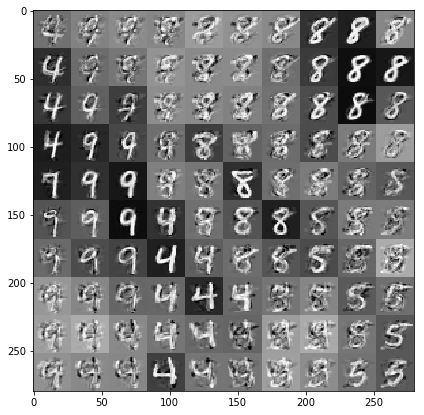

In [ ]:
samples = gprm.sample()

# Plot the grid of samples at new points. We do a bit of tweaking of the samples
# first, squeezing off extra 1-shapes and normalizing the values.
samples_ = np.squeeze(samples.numpy())
samples_ = ((samples_ -
             samples_.min(-1, keepdims=True)) /
            (samples_.max(-1, keepdims=True) -
             samples_.min(-1, keepdims=True)))
samples_ = samples_.reshape(sample_grid_points, sample_grid_points, 28, 28)
samples_ = samples_.transpose([0, 2, 1, 3])
samples_ = samples_.reshape(28 * sample_grid_points, 28 * sample_grid_points)
plt.figure(figsize=(7, 7))
ax = plt.subplot()
ax.grid(False)
ax.imshow(-samples_, interpolation='none', cmap='Greys')
plt.show()

## 結論

ガウス過程による潜在変数モデルを簡単に説明し、TF と TF Probability コードによるわずか数行でそれを実装できることを示しました。